# Brain Tumor Identification
By Jonathan Nunez

abstract

# Business Understanding

# Data Understanding

## Data preparation

In [21]:
# For Google Colab only
# Cell output cleared as it only contains installation progress information
!pip install keras
!pip install keras_preprocessing
!pip install tensorflow
!pip install scikeras[tensorflow]
!pip install split-folders

In [22]:
# Importing tools and modules for data preperation
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import array_to_img, img_to_array, load_img
import numpy as np
import splitfolders

In [23]:
# Code to create kaggle path for data download
# Code taken from stackoverflow user fdsig
import json
import os
from pathlib import Path

# your api key
api_key = {
'username':"",
'key':""}

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

In [24]:
# Downloading kaggle dataset
!kaggle datasets download -d ishans24/brain-tumor-dataset

# Making parent folder directory before data unzip
!mkdir /content/brain_tumor_dataset
!unzip brain-tumor-dataset.zip -d /content/brain_tumor_dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/brain_tumor_dataset/meningioma/meningioma515.png  
  inflating: /content/brain_tumor_dataset/meningioma/meningioma516.png  
  inflating: /content/brain_tumor_dataset/meningioma/meningioma517.png  
  inflating: /content/brain_tumor_dataset/meningioma/meningioma518.png  
  inflating: /content/brain_tumor_dataset/meningioma/meningioma519.png  
  inflating: /content/brain_tumor_dataset/meningioma/meningioma52.png  
  inflating: /content/brain_tumor_dataset/meningioma/meningioma520.png  
  inflating: /content/brain_tumor_dataset/meningioma/meningioma521.png  
  inflating: /content/brain_tumor_dataset/meningioma/meningioma522.png  
  inflating: /content/brain_tumor_dataset/meningioma/meningioma523.png  
  inflating: /content/brain_tumor_dataset/meningioma/meningioma524.png  
  inflating: /content/brain_tumor_dataset/meningioma/meningioma525.png  
  inflating: /content/brain_tumor_dataset/meningioma/meningioma526.png  
 

In [25]:
# Splitting data into train, test, val, directories
splitfolders.ratio('brain_tumor_dataset', output='b_tumor_data_split', seed=42, ratio=(.7, 0.15,0.15))

Copying files: 10560 files [00:23, 457.44 files/s]


In [26]:
# Creating directory paths
train_dir = 'b_tumor_data_split/train'
test_dir = 'b_tumor_data_split/test'
val_dir = 'b_tumor_data_split/val'

In [27]:
datagen = ImageDataGenerator(rescale=1./255)

In [28]:
train_generator = datagen.flow_from_directory(train_dir,
                                              target_size=(256, 256),
                                              batch_size=32,
                                              )

test_generator = datagen.flow_from_directory(test_dir,
                                             target_size=(256, 256),
                                             batch_size=32,
                                             )

val_generator = datagen.flow_from_directory(val_dir,
                                            target_size=(256, 256),
                                            batch_size=32,
                                            seed=42
                                            )

Found 7390 images belonging to 4 classes.
Found 1588 images belonging to 4 classes.
Found 1582 images belonging to 4 classes.


In [29]:
# Creating datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

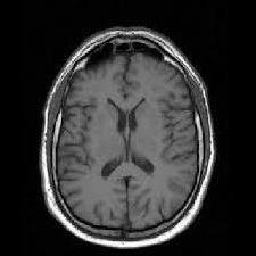

In [30]:
array_to_img(train_images[2])

# Modeling

In [43]:
# Importing modeling tools and modules
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.applications import ResNet50, DenseNet121

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [32]:
# Function to quickly plot model results
def plot_results(model_results):
    """
    This function will take in the results of a model and plot the loss and accuracy of the model.

    Args:
    model_results (list): the results of the model in [] brackets.
    """
    for results in model_results:
        train_loss = results.history['loss']
        train_acc = results.history['accuracy']
        val_loss = results.history['val_loss']
        val_acc = results.history['val_accuracy']

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
        sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

        sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
        sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
        ax1.set_title('Loss')
        ax2.set_title('Accuracy')
        ax1.legend();

In [33]:
# Function to quickly print out model evaluation for mulitple data sets
def model_evaluation(model, data_dict):
    """
    This function takes in a sequential model as a well as a dictionary of data and
    prints out the model evaluation results.

    Arguments:
    model: A trained model with .evaluate() capabilities
    data_dict: A dictionary where Keys are dataset names and Values are tuples (X, y) for data and labels.
    """
    for name, (X, y) in data_dict.items():
        loss, acc = model.evaluate(X, y)

        print(f'{name}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

### CNN Model

In [44]:
cnn_model = Sequential()

In [45]:
cnn_model.add(layers.Input(shape=(256, 256, 3)))
cnn_model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D())

cnn_model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D())

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))

In [46]:
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [47]:
cnn_results = cnn_model.fit(train_images, train_labels,
                            epochs=10,
                            validation_data=(val_images, val_labels))

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.4062 - loss: 1.3827 - val_accuracy: 0.5312 - val_loss: 3.0035
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7188 - loss: 2.0755 - val_accuracy: 0.2812 - val_loss: 10.0388
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2500 - loss: 6.9552 - val_accuracy: 0.3125 - val_loss: 3.3222
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.4062 - loss: 2.1691 - val_accuracy: 0.2812 - val_loss: 2.2551
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.5312 - loss: 1.6625 - val_accuracy: 0.3750 - val_loss: 2.6658
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6562 - loss: 1.7727 - val_accuracy: 0.3750 - val_loss: 1.9130
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6875 - loss: 1.0610 - val_accuracy: 0.5312 - val_loss: 1.0105
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9062 - loss: 0.4518 - val_accuracy: 0.4375 - val_loss: 1.2619
Epoch 9/10
1/1 

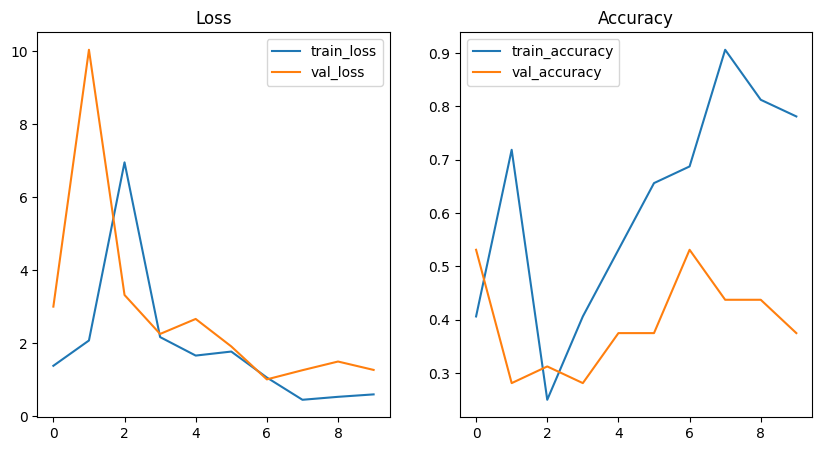

In [48]:
plot_results([cnn_results])

### DenseNet Model

### ResNet Model

# Evaluation

# Limitations

# Next Steps